## Este notebook es encargado de implementar un modelo para realizar la predicción del estado emocional de una sesión de prueba

In [1]:
import pickle
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np

In [2]:
model = pickle.load(open('./models/model', 'rb'))
# result_val = model.score(xval, yval)
# result_test = model.score(xtest, ytest)

In [5]:
df_to_predict = pd.read_csv("..//resources//csv//data//sujeto1-rocio-2020-10-25-biometrics.csv")
df.head()

,TimeStamp,HR,RR,HRV,MicroSiemens,SCR,SCR_MIN,ArousalMean,ValenceMean,ArousalSD,ValenceSD,PhaseName,MatchesSam
0,10/25/2020 19:00,84.9,707,0.10,0.91,0,0,0.0,0.0,0.0,0.0,NaN,False
1,10/25/2020 19:00,83.6,718,12.71,0.91,0,0,0.0,0.0,0.0,0.0,NaN,False
2,10/25/2020 19:00,80.9,742,0.00,0.91,0,0,0.0,0.0,0.0,0.0,NaN,False
3,10/25/2020 19:00,83.0,723,0.00,0.91,0,0,0.0,0.0,0.0,0.0,NaN,False
4,10/25/2020 19:00,83.8,716,0.00,0.90,0,0,0.0,0.0,0.0,0.0,NaN,False


In [7]:
# Función que determina cuando un sujeto se encuentra en un estado de excitación (1) o relajación (0) dado un valor de arousal.
def isAroused(arousal):
    return 0 if arousal < 5 else 1

In [9]:
df_to_standarize = df_to_predict.copy()
    
# Se remueven las mediciones sin estímulo (previas al inicio de estímulos), para no ofuscar el entrenamiento
filterNoArousalMeasurements = df_to_standarize['ArousalMean'] > 0
df_to_standarize = df_to_standarize[filterNoArousalMeasurements]

# remover las mediciones para las que el sam no coincidió antes de la estandarización, para no afectar la desviación
# filterNoMatchesSAMMeasurements = filtered1['MatchesSam'] == True
# df_to_standarize = df_to_standarize[filterNoMatchesSAMMeasurements]

# Se agrega la columna Aroused (0/1) para la clasificación binaria
df_to_standarize['Aroused'] = df_to_standarize['ArousalMean'].map(isAroused)

columns_to_standarize = ['HR', 'RR', 'HRV', 'MicroSiemens']

scaler = preprocessing.StandardScaler()
standarized_df = scaler.fit_transform(df_to_standarize[columns_to_standarize])

standarized_df_with_rest_of_data = np.append(standarized_df, df_to_standarize[['SCR', 'SCR_MIN', 'PhaseName', 'ArousalMean', 'Aroused']], axis=1)

# Se convierte a DataFrame
standarized_df_with_rest_of_data = pd.DataFrame(standarized_df_with_rest_of_data, columns=['HR', 'RR', 'HRV', 'MicroSiemens', 'SCR', 'SCR_MIN', 'PhaseName', 'ArousalMean', 'Aroused'])

# Conversión de tipos
standarized_df_with_rest_of_data['HR'] = standarized_df_with_rest_of_data['HR'].astype(float)
standarized_df_with_rest_of_data['RR'] = standarized_df_with_rest_of_data['RR'].astype(float)
standarized_df_with_rest_of_data['HRV'] = standarized_df_with_rest_of_data['HRV'].astype(float)
standarized_df_with_rest_of_data['MicroSiemens'] = standarized_df_with_rest_of_data['MicroSiemens'].astype(float)
standarized_df_with_rest_of_data['SCR'] = standarized_df_with_rest_of_data['SCR'].astype(int)
standarized_df_with_rest_of_data['SCR_MIN'] = standarized_df_with_rest_of_data['SCR_MIN'].astype(int)
standarized_df_with_rest_of_data['PhaseName'] = standarized_df_with_rest_of_data['PhaseName']
standarized_df_with_rest_of_data['ArousalMean'] = standarized_df_with_rest_of_data['ArousalMean'].astype(float)
standarized_df_with_rest_of_data['Aroused'] = standarized_df_with_rest_of_data['Aroused'].astype(int)

standarized_df_with_rest_of_data

df_to_predict = standarized_df_with_rest_of_data
df_to_predict

,HR,RR,HRV,MicroSiemens,SCR,SCR_MIN,PhaseName,ArousalMean,Aroused
0,0.180957,-0.246737,-0.638383,1.604263,0,0,HA_PV,6.070000,1
1,0.463350,-0.508771,-0.930989,1.357679,0,0,HA_PV,6.070000,1
2,0.419905,-0.468458,-1.085573,1.357679,0,0,HA_PV,6.070000,1
3,0.419905,-0.468458,-1.121459,1.111095,0,0,HA_PV,7.310000,1
4,0.506795,-0.549084,-1.088333,1.111095,0,0,HA_PV,7.310000,1
...,...,...,...,...,...,...,...,...,...
331,-1.252733,1.285155,2.776272,-1.847911,0,0,HA_NV,3.673077,0
332,-0.666224,0.619991,2.848043,-1.847911,0,0,HA_NV,3.673077,0
333,-1.013785,1.002964,2.837002,-1.847911,0,0,HA_NV,3.673077,0
334,-1.752352,1.869692,2.825960,-2.094495,0,0,HA_NV,3.673077,0


In [10]:
y_pred = model.predict(df_to_predict[['HR', 'HRV', 'MicroSiemens']])

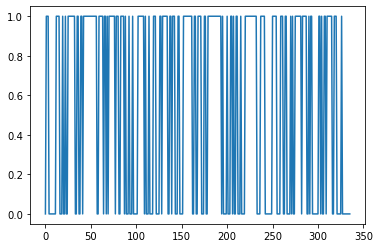

In [11]:
plt.plot(y_pred)
plt.show()

In [14]:
model.score(df_to_predict[['HR', 'HRV', 'MicroSiemens']], df_to_predict[['Aroused']])

0.49404761904761907

In [13]:
df_to_predict['ArousalPred'] = y_pred

df_to_predict.to_csv(r'./3_prediction.csv', index = False)